In [1]:
from __future__ import annotations

import operator
from pathlib import Path
from typing import TypedDict, List, Annotated, Literal

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [2]:
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=5,
        description="3–5 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(
        ...,
        description="Target word count for this section (120–450).",
    )
    section_type: Literal[
        "intro", "core", "examples", "checklist", "common_mistakes", "conclusion"
    ] = Field(
        ...,
        description="Use 'common_mistakes' exactly once in the plan.",
    )

In [3]:
class Plan(BaseModel):
    blog_title: str
    audience: str = Field(..., description="Who this blog is for.")
    tone: str = Field(..., description="Writing tone (e.g., practical, crisp).")
    tasks: List[Task]

In [4]:
class State(TypedDict):
    topic: str
    plan: Plan
    sections: Annotated[List[str], operator.add]  # reducer concatenates worker outputs
    final: str

In [5]:
llm = ChatOpenAI(model="gpt-4.1-mini")

In [6]:
def orchestrator(state: State) -> dict:
    planner = llm.with_structured_output(Plan)

    plan = planner.invoke(
        [
            SystemMessage(
                content=(
                    "You are a senior technical writer and developer advocate. Your job is to produce a "
                    "highly actionable outline for a technical blog post.\n\n"
                    "Hard requirements:\n"
                    "- Create 5–7 sections (tasks) that fit a technical blog.\n"
                    "- Each section must include:\n"
                    "  1) goal (1 sentence: what the reader can do/understand after the section)\n"
                    "  2) 3–5 bullets that are concrete, specific, and non-overlapping\n"
                    "  3) target word count (120–450)\n"
                    "- Include EXACTLY ONE section with section_type='common_mistakes'.\n\n"
                    "Make it technical (not generic):\n"
                    "- Assume the reader is a developer; use correct terminology.\n"
                    "- Prefer design/engineering structure: problem → intuition → approach → implementation → "
                    "trade-offs → testing/observability → conclusion.\n"
                    "- Bullets must be actionable and testable (e.g., 'Show a minimal code snippet for X', "
                    "'Explain why Y fails under Z condition', 'Add a checklist for production readiness').\n"
                    "- Explicitly include at least ONE of the following somewhere in the plan (as bullets):\n"
                    "  * a minimal working example (MWE) or code sketch\n"
                    "  * edge cases / failure modes\n"
                    "  * performance/cost considerations\n"
                    "  * security/privacy considerations (if relevant)\n"
                    "  * debugging tips / observability (logs, metrics, traces)\n"
                    "- Avoid vague bullets like 'Explain X' or 'Discuss Y'. Every bullet should state what "
                    "to build/compare/measure/verify.\n\n"
                    "Ordering guidance:\n"
                    "- Start with a crisp intro and problem framing.\n"
                    "- Build core concepts before advanced details.\n"
                    "- Include one section for common mistakes and how to avoid them.\n"
                    "- End with a practical summary/checklist and next steps.\n\n"
                    "Output must strictly match the Plan schema."
                )
            ),
            HumanMessage(content=f"Topic: {state['topic']}"),
        ]
    )

    return {"plan": plan}


In [7]:
def fanout(state: State):
    return [
        Send(
            "worker",
            {"task": task, "topic": state["topic"], "plan": state["plan"]},
        )
        for task in state["plan"].tasks
    ]

In [8]:
def worker(payload: dict) -> dict:

    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    section_md = llm.invoke(
        [
            SystemMessage(
    content=(
        "You are a senior technical writer and developer advocate. Write ONE section of a technical blog post in Markdown.\n\n"
        "Hard constraints:\n"
        "- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).\n"
        "- Stay close to the Target words (±15%).\n"
        "- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).\n\n"
        "Technical quality bar:\n"
        "- Be precise and implementation-oriented (developers should be able to apply it).\n"
        "- Prefer concrete details over abstractions: APIs, data structures, protocols, and exact terms.\n"
        "- When relevant, include at least one of:\n"
        "  * a small code snippet (minimal, correct, and idiomatic)\n"
        "  * a tiny example input/output\n"
        "  * a checklist of steps\n"
        "  * a diagram described in text (e.g., 'Flow: A -> B -> C')\n"
        "- Explain trade-offs briefly (performance, cost, complexity, reliability).\n"
        "- Call out edge cases / failure modes and what to do about them.\n"
        "- If you mention a best practice, add the 'why' in one sentence.\n\n"
        "Markdown style:\n"
        "- Start with a '## <Section Title>' heading.\n"
        "- Use short paragraphs, bullet lists where helpful, and code fences for code.\n"
        "- Avoid fluff. Avoid marketing language.\n"
        "- If you include code, keep it focused on the bullet being addressed.\n"
    )
)
,
            HumanMessage(
                content=(
                    f"Blog: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Topic: {topic}\n\n"
                    f"Section: {task.title}\n"
                    f"Section type: {task.section_type}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Bullets:{bullets_text}\n"
                )
            ),
        ]
    ).content.strip()

    return {"sections": [section_md]}




In [9]:
def reducer(state: State) -> dict:

    title = state["plan"].blog_title
    body = "\n\n".join(state["sections"]).strip()
    
    final_md = f"# {title}\n\n{body}\n"

    # Save to file
    filename = "".join(c if c.isalnum() or c in (" ", "_", "-") else "" for c in title)
    filename = filename.strip().lower().replace(" ", "_") + ".md"
    Path(filename).write_text(final_md, encoding="utf-8")

    return {"final": final_md}


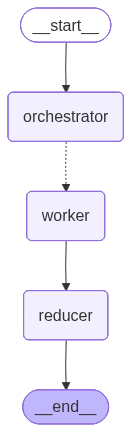

In [10]:
# -----------------------------
# 5) Graph
# -----------------------------
g = StateGraph(State)
g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reducer", reducer)

g.add_edge(START, "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()

app

In [11]:
out = app.invoke({"topic": "Write a blog on Self Attention", "sections": []})


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
print(out["final"])